### SAS® Viya®의 DecisionTreeClassifier를 사용한 손글씨 인식

#### 데이터셋에 대한 설명  
이 데이터는 [UCI ML 손글씨 숫자 데이터셋](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)의 테스트 세트 입니다.

이 예제는 이미지 인식, 특히 손글씨 숫자 인식에 초점을 맞춥니다.
데이터셋은 총 1797개의 관측치로 구성되어 있으며, 각각은 한 자리 숫자를 나타내는 손글씨 이미지로 이루어져 있습니다.
각 이미지는 가로 8픽셀, 세로 8픽셀 크기의 64픽셀로 구성됩니다.  

- **입력(𝐱)**  
  - 64차원의 벡터  
  - 각 입력 벡터는 하나의 이미지를 나타냄  
  - 벡터의 64개 값은 이미지의 픽셀에 해당  
  - 값의 범위: 0에서 16 (그레이스케일 명암을 나타냄)  
  - 숫자가 클수록 더 어두운 색상을 의미  

- **출력(𝑦)**  
  - 각 관측치에 대해 0에서 9 사이의 정수  
  - 이미지에 나타난 숫자를 의미  
  - 총 10개의 클래스 (0부터 9까지)  

### 1단계: 패키지 설치

Matplotlib와 scikit-learn의 다양한 패키지를 설치합니다.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sasviya.ml.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

### 2단계 a: 데이터 가져오기  

scikit-learn에서 `load_digits()`를 사용하여 데이터셋을 가져옵니다.
이 함수는 입력값과 출력값을 포함하는 튜플을 반환합니다.  

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

가져온 데이터를 시각화 합니다.

  - 6x6인치 크기의 도표를 설정하고, 서브플롯 간의 간격을 조정합니다.  
  - 8x8 픽셀 이미지로 이루어진 손글씨 데이터셋의 이미지를 8x8 그리드로 표시합니다.  
  - 각 서브플롯에는 해당 이미지에 연관된 목표값(target value)을 텍스트 레이블로 추가합니다. 

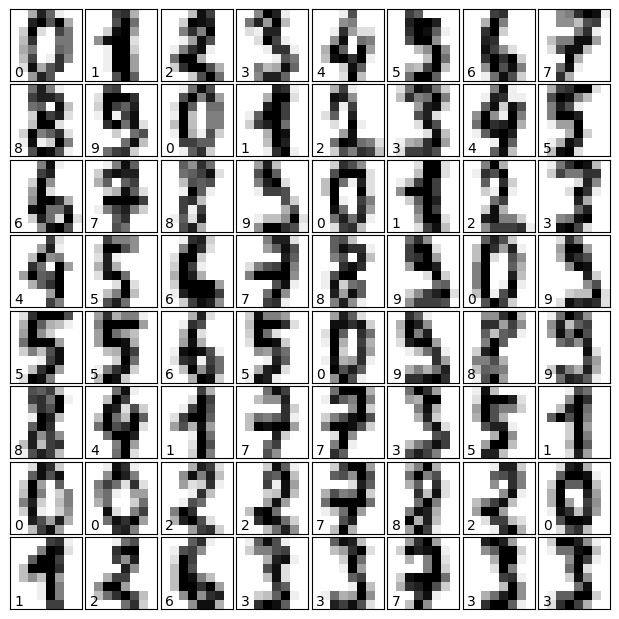

In [3]:
# 그림 설정
fig = plt.figure(figsize=(6, 6))  # 그림 크기 설정 (인치 단위)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 숫자들 그리기: 각 이미지는 8x8 픽셀
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 이미지에 목표값 레이블 추가
    ax.text(0, 7, str(digits.target[i]))

코드 `x, y = load_digits(return_X_y=True)`사용하여 scikit-learn 라이브러리에서 손글씨 데이터셋을 가져옵니다.

이 코드는 이미지 데이터(특징)와 숫자 레이블(목표값)을 각각 별도의 배열 변수로 분리하여 저장합니다.  
이를 통해 데이터는 추가 처리 및 모델 학습에 바로 사용할 수 있는 상태가 됩니다.  

In [4]:
x, y = load_digits(return_X_y=True)

작업할 데이터는 다음과 같습니다:  

- `x`:  
  - 다차원 배열  
  - 1797개의 행과 64개의 열로 구성  
  - 각 값은 0부터 16 사이의 정수  

In [5]:
x

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

- `y`:  
  - 1차원 배열  
  - 1797개의 정수로 구성  
  - 각 값은 0부터 9 사이의 정수

In [6]:
y

array([0, 1, 2, ..., 8, 9, 8])

### 2단계 b: 데이터 분할  

데이터셋을 무작위로 **훈련 세트**와 **테스트 세트**로 나눕니다.

- **훈련 세트**: 모델을 학습시키는 데 사용  
- **테스트 세트**: 모델의 성능을 평가하는 데 사용  
- **모델 학습 과정에서는 테스트 세트를 사용하지 않아야 합니다.**

데이터셋을 `train_test_split()`을 사용하여 훈련 세트와 테스트 세트로 나눕니다.

- **주요인자**
  - `test_size`: 테스트 세트의 크기를 결정  
  - `random_state`: 의사 난수 생성기의 상태를 설정  

- **결과**
  - `X_train`: 모델 학습에 사용되는 `x`의 일부  
  - `X_test`: 모델 평가에 사용되는 `x`의 일부  
  - `y_train`: `X_train`에 해당하는 `y`의 일부  
  - `y_test`: `X_test`에 해당하는 `y`의 일부  

`train_test_split()` 클래스 사용에 대한 자세한 내용은 [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)를 참고하세요.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### 3단계: `sasviya.ml.tree DecisionTreeClassifier`로 모델 생성 및 학습  

`x_train`과 `y_train` 데이터를 사용하여 모델을 학습시킵니다.  
`DecisionTreeClassifier`의 인스턴스를 생성한 후, `.fit()` 메서드를 호출하여 학습을 수행합니다.  

`DecisionTreeClassifier` 클래스 사용에 대한 자세한 내용은 [DecisionTreeClassifier 문서](https://documentation.sas.com/?cdcId=workbenchcdc&cdcVersion=default&docsetId=explore&docsetTarget=p14rqs4yfhf5bcn1js9nlfgzx795.htm)를 참고하세요.

In [8]:
dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=1,                           
                            criterion='gini')

dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=1)

`get_params()` 메서드를 사용하여 `DecisionTreeClassifier` 객체인 `dt`에서 사용된 파라미터를 조회할 수 있습니다.  
이 메서드는 모델에 설정된 파라미터들을 딕셔너리 형식으로 반환합니다.  

In [9]:
dt.get_params()

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'ccp_alpha': 0,
 'verbose': 0}

 `predict()` 메서드를 사용하여 예측된 출력을 반환합니다.  
 이 메서드는 훈련된 모델을 사용하여 입력 데이터에 대해 예측을 수행하고 결과를 반환합니다.    

In [10]:
y_pred = dt.predict(X_test)

In [11]:
y_pred

array([2, 9, 2, 6, 6, 7, 8, 9, 9, 2, 2, 9, 6, 6, 8, 6, 4, 0, 5, 9, 8, 9,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 5, 9, 8, 3, 1, 0, 9, 9, 6, 7, 7,
       9, 0, 7, 4, 8, 1, 9, 8, 2, 9, 9, 0, 4, 1, 6, 3, 0, 2, 3, 4, 8, 9,
       2, 6, 9, 8, 8, 2, 5, 1, 2, 8, 8, 2, 9, 7, 2, 3, 8, 0, 9, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 5, 7, 1, 8, 5, 1, 5, 1, 2, 5, 9, 0, 9, 3, 4, 5,
       2, 4, 9, 9, 7, 9, 9, 0, 8, 5, 2, 5, 8, 4, 1, 9, 0, 6, 1, 5, 1, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 8, 9, 6, 5, 6, 1, 5, 1, 5, 9, 9, 1, 1, 3,
       6, 1, 9, 9, 1, 7, 6, 7, 2, 5, 6, 0, 8, 1, 9, 3, 8, 1, 0, 4, 8, 6,
       3, 9, 6, 7, 4, 9, 6, 2, 9, 7, 3, 3, 0, 2, 7, 5, 7, 9, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 1, 3, 3, 0, 9, 5, 5, 9, 3, 4, 2, 1, 8, 9, 9,
       9, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 9, 2, 0, 7, 6, 1, 4,
       9, 9, 2, 9, 8, 5, 5, 7, 5, 8, 3, 7, 2, 7, 5, 5, 4, 0, 9, 1, 6, 5,
       9, 9, 4, 3, 8, 5, 3, 6, 4, 4, 3, 3, 6, 8, 8, 9, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 0, 5, 4, 3, 4, 8, 2, 9, 0,

`score()` 메서드를 사용하여 모델의 정확도를 계산합니다.  
이 메서드는 입력 값과 출력 값을 입력받아 모델의 정확도를 반환합니다.

훈련 세트와 테스트 세트에서 각각 정확도를 얻을 수 있습니다. 

만약 훈련 세트의 정확도가 테스트 세트보다 현저히 높다면, 이는 **과적합**(overfitting)을 나타낼 수 있습니다.  
테스트 세트의 정확도가 더 중요한 이유는, 테스트 세트가 모델이 보지 못한 데이터에 대한 성능을 평가하는 데 사용되기 때문입니다. 이는 편향되지 않은 평가를 제공합니다.  

In [18]:
print('Train Data Score: {:.4f}'.format(dt.score(X_train, y_train)))
print(' Test Data Score: {:.4f}'.format(dt.score(X_test, y_test)))

Train Data Score: 0.7947
 Test Data Score: 0.7278


`confusion_matrix()`를 사용하여 혼동 행렬을 얻을 수 있습니다.  
혼동 행렬은 모델이 예측한 값과 실제 값 간의 관계를 나타내며, 분류 모델의 성능을 평가하는 데 유용합니다.  

- **보라색 음영**: 작은 숫자(예: 0, 1, 2)를 의미  
- **초록색 및 노란색 음영**: 더 큰 숫자(21 이상)를 나타냅니다  

- **대각선 값**: 정확히 예측된 샘플 수
  - 각 클래스에서 정확히 분류된 이미지의 수를 나타냅니다.  
    - (예)
    - 숫자 0 → 24개  
    - 숫자 1 → 21개  
    - 숫자 2 → 37개  

- **대각선 외 값**: 잘못된 예측 (오분류)
  - 해당 클래스가 다른 클래스로 잘못 예측된 경우를 의미합니다.  
    - (예)세 번째 행과 첫 번째 열의 값 1 → 숫자 2가 숫자 0으로 잘못 예측된 경우

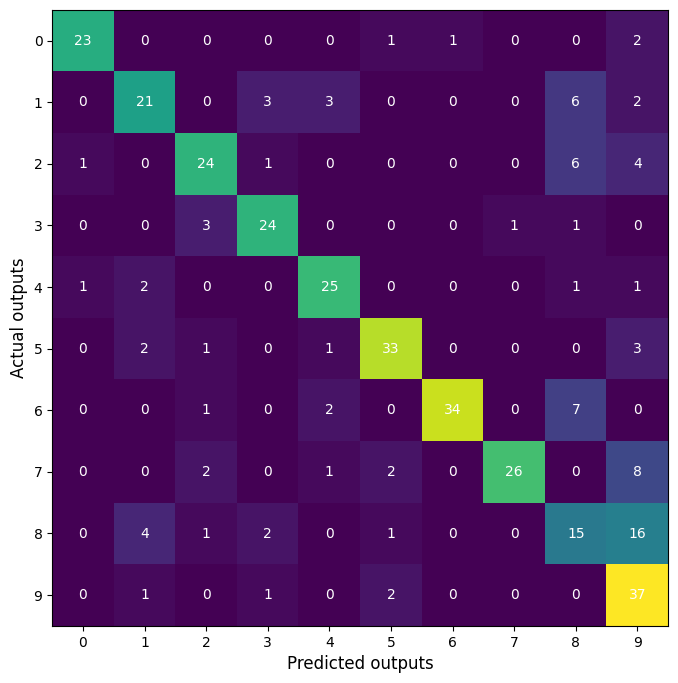

In [14]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(10))
ax.yaxis.set(ticks=range(10))
ax.set_ylim(9.5, -0.5)
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

마지막으로, `classification_report()`를 사용하여 분류 성능 보고서를 문자열 또는 딕셔너리 형태로 얻을 수 있습니다.  
이 보고서는 각 클래스에 대해 **정확도**, **정밀도**, **재현율**, **F1 점수** 등을 포함하여 모델의 성능을 자세히 보여줍니다.

- **주요지표**  
  - **Accuracy(정확도)**: 전체 샘플 중 올바르게 분류된 비율
  - **Precision(정밀도)**: 해당 클래스에 대해 양성으로 예측된 것 중 실제 양성의 비율
  - **Recall(재현율)**: 실제 양성 중 모델이 양성으로 예측한 비율
  - **Accuracy(정확도)**: 정밀도와 재현율의 조화 평균 (데이터 불균형 시 유용)
  

- **추가 정보**:
  - **Support(지원)**: 각 클래스의 실제 샘플 수
  - **Macro Average(매크로 평균)**: 모든 클래스 지표의 단순 평균 (클래스별 동일 가중치)
  - **Weighted Average(가중 평균e)**: 각 클래스의 샘플 수 기반 가중 평균 (데이터 불균형 고려)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        27
           1       0.70      0.60      0.65        35
           2       0.75      0.67      0.71        36
           3       0.77      0.83      0.80        29
           4       0.78      0.83      0.81        30
           5       0.85      0.82      0.84        40
           6       0.97      0.77      0.86        44
           7       0.96      0.67      0.79        39
           8       0.42      0.38      0.40        39
           9       0.51      0.90      0.65        41

    accuracy                           0.73       360
   macro avg       0.76      0.73      0.74       360
weighted avg       0.76      0.73      0.73       360

